### Import required packages

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from nltk.sentiment import SentimentIntensityAnalyzer

### Load spacy model

In [51]:
# Load resources
import spacy
nlp = spacy.load("en_core_web_lg")
sia = SentimentIntensityAnalyzer()

c:\Users\vl4di\anaconda3\envs\block_c2\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_lg' (3.4.1) was trained with spaCy v3.4.0 and may not be 100% compatible with the current version (3.8.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Load the dataset

In [52]:
df = pd.read_csv('test_set_with_features.csv')
df.head()

,Translation,Core_Emotion,Tokens,POS_Tags_new,Sentiment_Score_new,GloVe_Embedding_new
0,Sofia. Lilyana Georgieva and her 13-year-old d...,neutral,"['sofia', '.', 'lilyana', 'georgieva', 'and', ...","['PROPN', 'PUNCT', 'PROPN', 'PROPN', 'CCONJ', ...",0.0000,"[0.020633583888411522, 0.20872867107391357, 0...."
1,Ever since Velina's father abandoned her famil...,sadness,"['ever', 'since', 'velina', ""'s"", 'father', 'a...","['ADV', 'SCONJ', 'PROPN', 'PART', 'NOUN', 'VER...",-0.4588,"[0.03035452589392662, 0.15139038860797882, -0...."
2,There is almost no desire that Liliana does no...,happiness,"['there', 'is', 'almost', 'no', 'desire', 'tha...","['PRON', 'VERB', 'ADV', 'DET', 'NOUN', 'PRON',...",-0.2243,"[0.016226692125201225, 0.18178969621658325, -0..."
3,Velina has a very difficult time to make a sta...,sadness,"['velina', 'has', 'a', 'very', 'difficult', 't...","['PROPN', 'VERB', 'DET', 'ADV', 'ADJ', 'NOUN',...",-0.3604,"[0.02610410377383232, 0.20006246864795685, -0...."
4,So I allowed myself to buy her whatever she wa...,neutral,"['so', 'i', 'allowed', 'myself', 'to', 'buy', ...","['ADV', 'PRON', 'VERB', 'PRON', 'PART', 'VERB'...",0.0000,"[0.03702537342905998, 0.15453578531742096, -0...."


In [53]:
df['Core_Emotion'].isnull().sum()

0

### Pre process Tokens

In [54]:
import ast
# === Safe converter for Tokens column ===
def safe_tokens_to_str(x):
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)  # Convert stringified list to real list
        except:
            return ""
    if isinstance(x, list):
        return ' '.join(x)  # Join list to space-separated string
    return ""

# === Apply clean conversion ===
df['Tokens_str'] = df['Tokens'].apply(safe_tokens_to_str)

# === Tokenization ===
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Tokens_str'])
sequences = tokenizer.texts_to_sequences(df['Tokens_str'])

# === Padding ===
max_len = 32
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

### Check average Sequence Length

In [55]:
# First make sure 'Tokens' is a list, not a string
import ast

df["Tokens"] = df["Tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["seq_len"] = df["Tokens"].apply(len)

# Summary statistics
print("🔍 Sequence length stats:")
print(df["seq_len"].describe())

🔍 Sequence length stats:
count    941.000000
mean       8.131775
std        3.951792
min        1.000000
25%        5.000000
50%        7.000000
75%       10.000000
max       30.000000
Name: seq_len, dtype: float64


### Pre process POS TAGS

In [56]:
df['POS_Tags_new'] = df['POS_Tags_new'].apply(lambda x: eval(x) if isinstance(x, str) else x)
all_tags = [tag for seq in df['POS_Tags_new'] for tag in seq]
le_pos = LabelEncoder()
le_pos.fit(all_tags)

df['POS_Encoded'] = df['POS_Tags_new'].apply(lambda tags: le_pos.transform(tags))
pos_padded = pad_sequences(df['POS_Encoded'], maxlen=max_len, padding='post')

### Pre Process Sentiment Score

In [57]:
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(df[['Sentiment_Score_new']])

### Pre Process Glove Embeddings

In [58]:
df['GloVe_Embedding_new'] = df['GloVe_Embedding_new'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.zeros(300))
glove_features = np.vstack(df['GloVe_Embedding_new'].values)

In [59]:
pos_padded[0]

array([11, 12, 11, 11,  4, 10,  8, 12,  7, 12,  0,  7,  7, 14,  1,  5,  0,
        0,  7, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

### Pre Process Labels

In [60]:
label_encoder = LabelEncoder()
int_labels = label_encoder.fit_transform(df['Core_Emotion'])
onehot_encoder = OneHotEncoder(sparse_output=False)
labels = onehot_encoder.fit_transform(int_labels.reshape(-1, 1))

In [61]:
# Mapping of labels to encoded values
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(label_mapping)

{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


### Define model inputs

In [62]:
X_text = padded_sequences
X_pos = pos_padded
X_sentiment = sentiment_scaled
X_glove = glove_features
y = labels

### Define F1 function

In [63]:
import tensorflow.keras.backend as K
import tensorflow as tf

def f1_micro(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

### Make predictions on the test set using the best RNN model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("emotion_model_v9.keras", custom_objects={'f1_micro': f1_micro})



# Predict on test set
y_pred_proba = model.predict([X_text, X_pos, X_sentiment, X_glove])
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y, axis=1)

C:\Users\vl4di\AppData\Roaming\Python\Python39\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


### Decode the predictions

In [ ]:
# Decode predictions 
predicted_emotions = label_encoder.inverse_transform(y_pred)
true_emotions = label_encoder.inverse_transform(y_true)

### Classification Report of the predictions

              precision    recall  f1-score   support

       anger       0.39      0.08      0.13       237
     disgust       0.02      1.00      0.03         3
        fear       0.00      0.00      0.00        26
   happiness       0.40      0.22      0.28       142
     neutral       0.51      0.65      0.57       389
     sadness       0.11      0.02      0.03       129
    surprise       0.00      0.00      0.00        15

    accuracy                           0.33       941
   macro avg       0.20      0.28      0.15       941
weighted avg       0.38      0.33      0.32       941



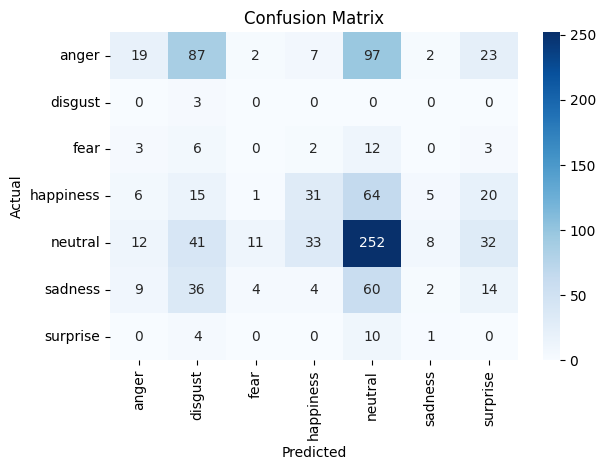

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Classification report
print(classification_report(true_emotions, predicted_emotions))

# Confusion matrix
cm = confusion_matrix(true_emotions, predicted_emotions, labels=label_encoder.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


### F1 scores of the predictions

In [67]:
from sklearn.metrics import f1_score

# F1 scores
f1_macro = f1_score(true_emotions, predicted_emotions, average='macro')
f1_weighted = f1_score(true_emotions, predicted_emotions, average='weighted')
f1_micro = f1_score(true_emotions, predicted_emotions, average='micro')
f1 = f1_score(true_emotions, predicted_emotions, average=None)

print(f"🔍 F1 Macro:     {f1_macro:.4f}")
print(f"🔍 F1 Weighted:  {f1_weighted:.4f}")
print(f"🔍 F1 Micro:     {f1_micro:.4f}")
print(f"🔍 F1 Scores:    {f1}")

🔍 F1 Macro:     0.1492
🔍 F1 Weighted:  0.3157
🔍 F1 Micro:     0.3262
🔍 F1 Scores:    [0.13286713 0.03076923 0.         0.28310502 0.57013575 0.02721088
 0.        ]
